# Strategy

- S&P 500 (SPY) vs Intermediate-term US Treasuries (IEF)
- Gold (GLD) vs Long-term US Treasuries (TLT)
- US Real Estate (VNQ) vs Intermediate-term US Treasuries (IEF)


![strategy_params](strategy_params.png)


[More info](https://allocatesmartly.com/stokens-active-combined-asset-strategy/)

IEF - 7-10 years bonds

TLT - 20+ bonds


In [1]:
CONFIG = {
  'SPY': {'upper': 126, 'lower': 252, 'defensive_asset': 'IEF'},
  'GLD': {'upper': 252, 'lower': 126, 'defensive_asset': 'TLT'},
  'VNQ': {'upper': 126, 'lower': 252, 'defensive_asset': 'IEF'}
}

In [2]:
import numpy as np

ASSETS = set(np.array([
  [asset, config['defensive_asset']] 
    for (asset, config) in CONFIG.items()
]).flat)

ASSETS

{'GLD', 'IEF', 'SPY', 'TLT', 'VNQ'}

# Load assets history

We will use yahoo finance client to load dividends and prices history for our `ASSETS`.

In [3]:
# pip install --user pandas numpy datetime scipy pandas_datareader yfinance

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta

yf.pdr_override()

In [32]:
def load_max_history(assets):
  df = None

  for asset in assets:
    data = yf.Ticker(asset).history(period='max')
    columns = pd.MultiIndex.from_product(
      [data.columns, [asset]],
      names=['property', 'asset']
    )
    multi_level_df = pd.DataFrame(data.values, index=data.index, columns=columns)
    # display(multi_level_df.columns.to_numpy())
    if df is None:
      df = multi_level_df
    else:
      df = df.join(multi_level_df)

  df = df[sorted(df.columns)]
  return df.dropna()

df = load_max_history(ASSETS)[['Close', 'Dividends']]
df.head()

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2004-11-18  44.380001  55.061237  84.752510  51.618942  25.282896       0.0   
2004-11-19  44.779999  54.759525  83.810326  51.207062  25.021568       0.0   
2004-11-22  44.950001  54.798054  84.210060  51.473900  25.194227       0.0   
2004-11-23  44.750000  54.746658  84.338547  51.537731  25.301556       0.0   
2004-11-24  45.049999  54.823719  84.538391  51.537731  25.740202       0.0   

property                        
asset       IEF  SPY  TLT  VNQ  
Date                            
2004-11-18  0.0  0.0  0.0  0.0  
2004-11-19  0.0  0.0  0.0  0.0  
2004-11-22  0.0  0.0  0.0  0.0  
2004-11-23  0.0  0.0  0.0  0.0  
2004-11-24  0.0  0.0  0.0  0.0

# Stategy evaluaton

Create upper and lower channels for risk-on assets defined in the `CONFIG`.

In [ ]:
from operator import itemgetter

In [33]:
for (risk_asset, config) in CONFIG.items():
  (upper_channel_window, lower_channel_window) = itemgetter('upper', 'lower')(config)
  close_prices = df.Close[risk_asset]

  df['Upper_Channel', risk_asset] = close_prices\
    .rolling(window=upper_channel_window).max().shift(1)
  df['Lower_Channel', risk_asset] = close_prices\
    .rolling(window=lower_channel_window).min().shift(1)

df = df[sorted(df.columns)]

In [35]:
df.iloc[250:].head() # deliberate shift to check the first moment where 252 lower/upper channel appeared for the first time

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2005-11-15  46.660000  55.254726  89.464447  54.242771  29.501310       0.0   
2005-11-16  47.779999  55.534737  89.645943  54.813034  29.333395       0.0   
2005-11-17  48.480000  55.641392  90.480766  54.946541  29.817362       0.0   
2005-11-18  48.459999  55.508087  90.836479  54.691681  29.925987       0.0   
2005-11-21  48.990002  55.614761  91.293808  54.855503  30.074144       0.0   

property                       Lower_Channel                        \
asset       IEF  SPY  TLT  VNQ           GLD        SPY        VNQ   
Date                                                                 
2005-11-15  0.0  0.0  0.0  0.0     41.529999        NaN        NaN   
2005-11-16  0.0  0.0  0.0  0.0     41.529999        NaN        NaN   
2005-11-17  0.0  0.0  0.0  0.0     41.529999  81.930779  24.664749   
2005-11-18  0.0  0.0  0.0  0.0     41.529999  81.930779  24.664749   
2005-11-21  0.0  0.0  0.0  0.0     41.529999  81.930779  24.664749   

property   Upper_Channel                        
asset                GLD        SPY        VNQ  
Date                                            
2005-11-15           NaN  90.155075  30.903227  
2005-11-16           NaN  90.155075  30.903227  
2005-11-17     47.779999  90.155075  30.903227  
2005-11-18     48.480000  90.480766  30.903227  
2005-11-21     48.480000  90.836479  30.903227

In [34]:
df.iloc[124:].head() # deliberate shift to check the first moment where 126 lower/upper channel appeared for the first time

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2005-05-18  42.049999  56.360676  85.523315  55.499554  27.330286       0.0   
2005-05-19  41.980000  56.190639  85.883324  55.357185  27.692450       0.0   
2005-05-20  41.650002  56.184097  85.760918  55.422451  27.750385       0.0   
2005-05-23  41.619999  56.439182  86.236076  55.855408  27.813171       0.0   
2005-05-24  41.730000  56.589592  86.034500  56.009659  27.426867       0.0   

property                       Lower_Channel         Upper_Channel             \
asset       IEF  SPY  TLT  VNQ           GLD SPY VNQ           GLD        SPY   
Date                                                                            
2005-05-18  0.0  0.0  0.0  0.0           NaN NaN NaN           NaN        NaN   
2005-05-19  0.0  0.0  0.0  0.0           NaN NaN NaN           NaN        NaN   
2005-05-20  0.0  0.0  0.0  0.0     41.259998 NaN NaN           NaN  88.057304   
2005-05-23  0.0  0.0  0.0  0.0     41.259998 NaN NaN           NaN  88.057304   
2005-05-24  0.0  0.0  0.0  0.0     41.259998 NaN NaN           NaN  88.057304   

property               
asset             VNQ  
Date                   
2005-05-18        NaN  
2005-05-19        NaN  
2005-05-20  27.692450  
2005-05-23  27.750385  
2005-05-24  27.813171

## Run strategy

In [283]:
from dotmap import DotMap
import rpar

SLIPPAGE = 0.01
FEE = 0.02
TAX = 0.15 # we pay 15% tax on dividends here (but it can vary a lot depending on circumstances)

cash = 50000 # initial cash
portfolio = []

def flatten_portfolio(portfolio): 
  dict = {}
  for item in portfolio:
    dict[item['asset']] = item['amount']
  return dict

results = DotMap(portfolio_value=[], cash=[], portfolio=[], last_fractions=[])

total_fees = 0

# RISK_BALANCE_WINDOW = float('inf')
RISK_BALANCE_WINDOW = 2 * 256

# history = df.iloc[0:5]
history = df
for x in range(0, len(history)):

  today = history.iloc[x]
  close_price = today.Close
  dividends = today.Dividends

  fractions = {}

  # initialize portfolio - start with risk on
  if len(portfolio) == 0:
    portfolio = [{}] * len(CONFIG)
    assets = CONFIG.keys()
    portfolio_value = cash
    fractions = dict(zip(assets, [1 / len(assets)] * len(assets)))

    for (index, (asset, config)) in enumerate(CONFIG.items()):
      portfolio[index] = {'asset': asset, 'amount': 0}
      # we will open positions later during the rebalance phase

  # add dividends
  for item in portfolio:
    (asset, amount) = itemgetter('asset', 'amount')(item)
    maybe_divs = dividends[asset]
    if not np.isnan(maybe_divs):
      cash += (amount * maybe_divs) * (1 - TAX) 

  # check if need to replace some assets with defensive assets
  upper_channel = today.Upper_Channel
  lower_channel = today.Lower_Channel

  new_assets = []

  for (index, (risk_asset, config)) in enumerate(CONFIG.items()):
    my_asset = portfolio[index]['asset']
    if not pd.isna(upper_channel[risk_asset]) and close_price[risk_asset] > upper_channel[risk_asset]:
      new_assets.append(risk_asset)
    elif not pd.isna(lower_channel[risk_asset]) and close_price[risk_asset] < lower_channel[risk_asset]:
      new_assets.append(config['defensive_asset'])
    else:
      new_assets.append(my_asset)

  needs_rotation = any(new_asset != item['asset'] for (new_asset, item) in zip(new_assets, portfolio))
  if needs_rotation:
    # maybe update risk balanced weights based on the previous RISK_BALANCE_WINDOW prices
    # note: if RISK_BALANCE_WINDOW = float('inf') this will never happen in this case - always use equal weight
    fractions = dict(zip(new_assets, [1 / len(new_assets)] * len(new_assets)))
    if x > RISK_BALANCE_WINDOW:
      fractions = dict(rpar.get_weights(df.iloc[x - RISK_BALANCE_WINDOW:x].Close[new_assets]))
      # this protects from cases when a single asset is repeated twice e.g. IEF/GLD/IEF state
      for (k, v) in fractions.items():
        if isinstance(fractions[k], pd.Series): 
          fractions[k] = v[0]

    for (index, item) in enumerate(portfolio):
      # do we need to replace the item (i.e. switch risk/defensive)
      if new_assets[index] != item['asset']:
        # sell current asset, we will buy new asset later during rebalance
        cash += item['amount'] * (close_price[item['asset']] - SLIPPAGE)

        fee = item['amount'] * FEE
        cash -= fee
        total_fees += fee

        item['asset'] = new_assets[index] 
        item['amount'] = 0

  # calculate current portfolio value
  portfolio_value = cash
  for item in portfolio:
    (asset, amount) = itemgetter('asset', 'amount')(item)
    portfolio_value += (close_price[asset] - SLIPPAGE - FEE) * amount

  if len(fractions) == 0: 
    fractions = results.last_fractions[-1] 

  for item in portfolio:
    asset = item['asset']
    price = close_price[asset]
    new_amount = np.floor(portfolio_value * fractions[asset] / price)
    diff = item['amount'] - new_amount
    if diff != 0:
      # rebalance
      if diff > 0: # => item['amount'] > new_amount => sell
        cash += diff * (price - SLIPPAGE)
      else: # => item['amount'] < new_amount => buy
        cash += diff * (price + SLIPPAGE)

      fee = abs(diff) * FEE
      cash -= fee
      total_fees += fee

      item['amount'] = new_amount

  # calculate updated portfolio value
  portfolio_value = cash
  for item in portfolio:
    (asset, amount) = itemgetter('asset', 'amount')(item)
    portfolio_value += (close_price[asset] - SLIPPAGE - FEE) * amount

  results.portfolio_value.append(portfolio_value)
  results.cash.append(cash)
  results.portfolio.append(flatten_portfolio(portfolio))
  results.last_fractions.append(fractions)

result_df = pd.DataFrame(results, index=history.index)

# dumping results dataframe to HTML can be good for debug purposes
#
# with open('out.html', 'w') as file:
#   file.write(history.join(result_df).to_html())


## Portfolio states

In [285]:
result_df.head()

,portfolio_value,cash,portfolio,last_fractions
Date,,,,
2004-11-18,49926.200000,47.679134,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 659.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2004-11-19,49719.076007,112.434097,"{'SPY': 197.0, 'GLD': 370.0, 'VNQ': 662.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2004-11-22,49975.024642,137.598325,"{'SPY': 197.0, 'GLD': 370.0, 'VNQ': 661.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2004-11-23,49997.160309,123.852991,"{'SPY': 197.0, 'GLD': 372.0, 'VNQ': 658.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2004-11-24,50436.638640,122.755611,"{'SPY': 198.0, 'GLD': 373.0, 'VNQ': 653.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."


In [286]:
result_df.tail()

,portfolio_value,cash,portfolio,last_fractions
Date,,,,
2022-01-14,377709.660904,449.110874,"{'SPY': 213.0, 'TLT': 1475.0, 'VNQ': 628.0}","{'SPY': 0.2628038135294329, 'TLT': 0.555115031..."
2022-01-18,372284.407605,317.460883,"{'SPY': 214.0, 'TLT': 1475.0, 'VNQ': 625.0}","{'SPY': 0.2628038135294329, 'TLT': 0.555115031..."
2022-01-19,371787.702068,392.300973,"{'SPY': 216.0, 'TLT': 1462.0, 'VNQ': 633.0}","{'SPY': 0.2628038135294329, 'TLT': 0.555115031..."
2022-01-20,371111.883191,321.111015,"{'SPY': 218.0, 'TLT': 1451.0, 'VNQ': 640.0}","{'SPY': 0.2628038135294329, 'TLT': 0.555115031..."
2022-01-21,371485.462644,656.151043,"{'SPY': 222.0, 'TLT': 1435.0, 'VNQ': 642.0}","{'SPY': 0.2628038135294329, 'TLT': 0.555115031..."


# Total annualized returns

In [287]:
first = result_df.iloc[0]
last = result_df.iloc[-1]

years = (last.name - first.name).days / 365.25

annualized_return = (last['portfolio_value']  / first['portfolio_value']) ** (1/years) - 1

print(
  """Annualized return is: %.2f%%
over the period of %.2f years
from %s to %s""" % (
    100 * annualized_return,
    years,
    date.fromtimestamp(first.name.timestamp()), 
    date.fromtimestamp(last.name.timestamp())
  )
)


Annualized return is: 12.40%
over the period of 17.17 years
from 2004-11-18 to 2022-01-21


# Overall performance

## Free cash

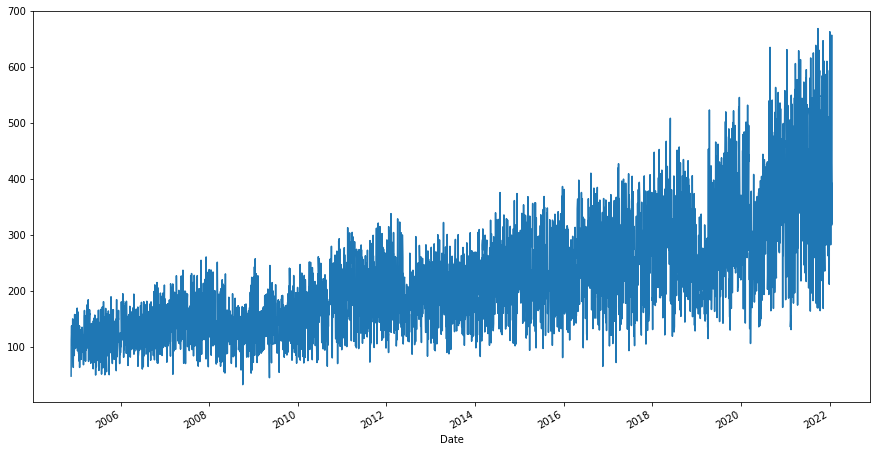

In [288]:
result_df.cash.plot(figsize=(15, 8))

## Equity

Initial investment at 2004-11-18: 10000
Last value at 2022-01-21: 74406.92


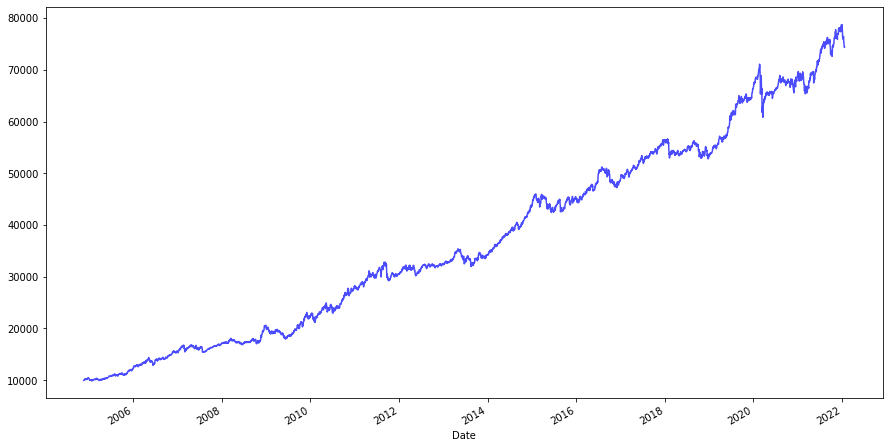

In [289]:
log_returns = np.log(result_df.portfolio_value).diff()

cum_returns = log_returns.cumsum() 

CAPITAL = 10000

perf = CAPITAL * np.exp(cum_returns)
plt.figure()
perf.plot(figsize=(15,8), color='b', alpha=0.7)

print(f'Initial investment at {perf.index[0].date()}: {CAPITAL}')
print(f'Last value at {perf.index[-1].date()}: {perf[-1]:.2f}')

In [290]:
TRADING_DAYS_YEARLY = 252
# RISK_FREE_RATE = 0.02
RISK_FREE_RATE = 0.00

annual_return = np.exp(log_returns.mean() * TRADING_DAYS_YEARLY) - 1
annual_volatility = log_returns.std() * np.sqrt(TRADING_DAYS_YEARLY)

sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility

annualized_downside = log_returns.loc[log_returns<0].std() * np.sqrt(TRADING_DAYS_YEARLY)
sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

print(
  f"""Annulaized return {(annual_return * 100):.2f}%
Annualized volatility {(annual_volatility * 100):.2f}%
Sharpe ratio {sharpe_ratio:.2f}
Sortino ratio {sortino_ratio:.2f}
""" 
)

Annulaized return 12.41%
Annualized volatility 9.83%
Sharpe ratio 1.26
Sortino ratio 1.66



# Returns by month/by year

In [291]:

def montly_results(result_df):
  initial_value = result_df['portfolio_value'][0]

  grouping = pd.MultiIndex.from_tuples(
    zip(result_df.index.year, result_df.index.month),
    names=['year', 'month']
  )

  by_month = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_month = by_month.join(by_month.shift(1).add_prefix('prev_')).fillna(initial_value)

  table = pd.DataFrame(
    {
      'change': 100 * (by_month['portfolio_value'] / by_month['prev_portfolio_value'] - 1),
    },
    index = grouping
  ).dropna().reset_index()

  montly_results = table.pivot_table(index=['year'], columns=['month'], values=['change'])

  grouping = result_df.index.year
  by_year = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_year = by_year.join(by_year.shift(1).add_prefix('prev_')).fillna(initial_value)

  montly_results['total'] = 100 * (by_year['portfolio_value'] / by_year['prev_portfolio_value'] - 1)

  return montly_results

pd.options.display.float_format = lambda x: 'N/A' if np.isnan(x) else '{:,.2f}%'.format(x)
display(montly_results(result_df))
pd.options.display.float_format = None 


change                                                                 \
month      1      2      3      4      5      6      7      8      9     10   
year                                                                          
2004     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005  -4.81%  2.82% -0.85%  1.69%  0.90%  3.83%  3.14% -1.20%  4.09% -1.92%   
2006   6.61%  0.48%  3.87%  3.19% -2.23%  0.95%  2.54%  1.45%  0.73%  3.51%   
2007   4.26% -0.69% -0.19%  2.12%  0.25% -3.37% -3.67%  2.24%  2.70%  2.17%   
2008   1.36%  2.16%  0.56% -2.32% -1.35%  0.39%  1.23%  0.61%  1.43% -3.33%   
2009  -6.16% -0.61%  3.81% -3.46% -2.12% -0.41%  2.67%  4.19%  2.81%  0.68%   
2010  -2.66%  3.61%  3.53%  4.81% -1.61% -0.74%  0.79%  1.39%  6.42%  3.91%   
2011  -2.21%  5.03%  0.93%  6.56% -1.06% -1.98%  4.06%  4.17% -9.24%  2.09%   
2012   2.96% -0.26%  1.94%  0.40% -3.89%  1.96%  2.83%  0.23% -0.37% -0.82%   
2013   0.60%  1.41%  1.91%  4.38% -3.74% -1.90%  0.71% -2.75%  2.47%  3.13%   
2014   2.85%  2.74%  1.16%  2.05%  2.80%  1.20%  0.10%  4.33% -2.16%  4.15%   
2015   5.29% -2.06%  0.78% -2.41% -0.74% -3.05%  4.23% -3.21%  1.35%  3.54%   
2016   0.64%  0.73%  2.54%  1.06% -1.25%  6.03%  3.19% -2.26%  0.15% -3.28%   
2017   0.96%  2.94% -0.36%  1.18%  1.25%  1.52%  0.81%  1.60%  0.18%  0.67%   
2018  -0.65% -3.91% -0.01% -0.52%  1.19%  0.18%  1.02%  2.40% -0.99% -4.27%   
2019   3.00% -0.30%  3.98% -0.29%  1.46%  5.28%  0.87%  4.31% -0.30%  2.13%   
2020   2.46% -4.20% -2.06%  1.85%  0.89%  0.69%  2.98%  0.14% -1.08% -1.34%   
2021  -1.94% -1.61% -0.63%  4.27%  0.40%  3.82%  3.63%  1.05% -3.61%  4.58%   
2022  -5.44%    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                     total  
month     11     12         
year                        
2004   0.94%  3.14%  4.11%  
2005   4.80%  3.37% 16.52%  
2006   4.60%  0.49% 29.21%  
2007   1.74%  1.28%  8.85%  
2008   9.78%  7.99% 19.25%  
2009   9.75% -1.71%  8.84%  
2010   0.85%  4.50% 27.30%  
2011   0.22%  0.50%  8.38%  
2012   0.76%  0.43%  6.16%  
2013  -1.32%  0.69%  5.38%  
2014   2.85%  2.66% 27.53%  
2015  -0.31%  0.37%  3.39%  
2016  -1.74%  2.44%  8.18%  
2017   2.08%  1.85% 15.67%  
2018   2.58% -2.09% -5.21%  
2019  -0.93%  3.10% 24.46%  
2020  -1.60%  5.70%  4.13%  
2021   1.06%  2.17% 13.57%  
2022     NaN    NaN -5.44%

# Drawdown analysis

Text(0, 0.5, 'Drawdown, %')

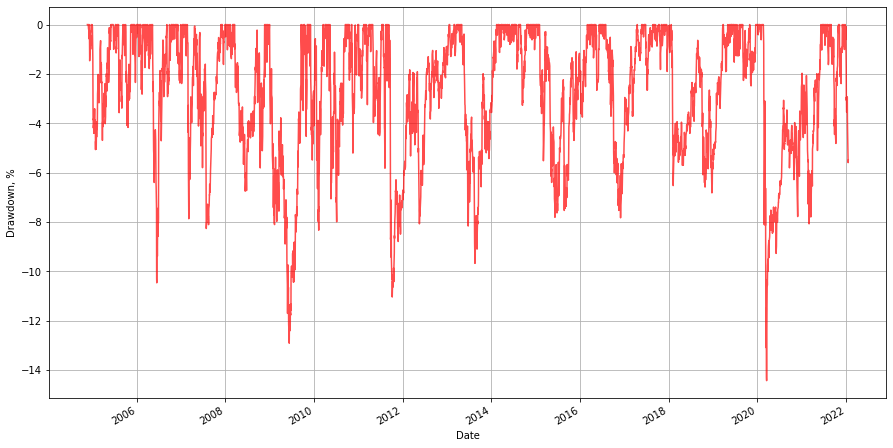

In [292]:
last_peak = cum_returns.cummax()

log_dd = cum_returns - last_peak

pct_dd = (np.exp(log_dd) - 1) * 100

ax = pct_dd.plot(figsize=(15,8), color='r', alpha=0.7)
ax.grid(axis='both')
ax.set_ylabel('Drawdown, %')

# plt.savefig('drawdown_evaluation.svg')


## Longest/max drawdowns

In [293]:

def find_true_streaks(array):
  # finds all "True" streaks in array from longest to shortest

  masked = np.concatenate(([False], array, [False]))       
  true_streaks = np.flatnonzero(masked[1:] != masked[:-1]).reshape(-1, 2) 
  ends = true_streaks[:,1]
  true_streaks_descending = (true_streaks[:,1] - true_streaks[:,0]).argsort()[::-1]
  return true_streaks[true_streaks_descending]

dd_streaks = find_true_streaks(pct_dd.values != 0)

def print_streak(n):
  start, end = dd_streaks[n]
  days = (pct_dd.index[end] - pct_dd.index[start]).days
  years = days / 365.25
  months = years * 12

  print(
    f"""#{n + 1}: Drawdown: {days} days = {months:.2f} months = {years:.2f} years
From {pct_dd.index[start].date()} to {pct_dd.index[end].date()}""" 
  )

print("Longest drawdowns")
for i in range(5):
  if dd_streaks.size <= i: break
  print_streak(i)

if dd_streaks.size == 0:
  print("No drawdown found")

print()
max_dd_index = np.argmin(pct_dd)
print(f"""Max drawdown {pct_dd.iloc[max_dd_index]:.2f}% on {pct_dd.index[max_dd_index].date()}""")

Longest drawdowns
#1: Drawdown: 497 days = 16.33 months = 1.36 years
From 2011-09-09 to 2013-01-18
#2: Drawdown: 471 days = 15.47 months = 1.29 years
From 2020-02-24 to 2021-06-09
#3: Drawdown: 425 days = 13.96 months = 1.16 years
From 2018-01-24 to 2019-03-25
#4: Drawdown: 394 days = 12.94 months = 1.08 years
From 2015-02-03 to 2016-03-03
#5: Drawdown: 286 days = 9.40 months = 0.78 years
From 2013-05-03 to 2014-02-13

Max drawdown -14.43% on 2020-03-19


## Drawdown quantiles

Quantiles:
50.0% of time expected drawdown is no more than 2.18% theoretically or 2.57% actually
75.0% of time expected drawdown is no more than 4.35% theoretically or 4.72% actually
95.0% of time expected drawdown is no more than 9.41% theoretically or 7.83% actually
99.0% of time expected drawdown is no more than 14.46% theoretically or 10.42% actually
Max DD was 14.43%
Last DD (2022-01-21) was 5.50%


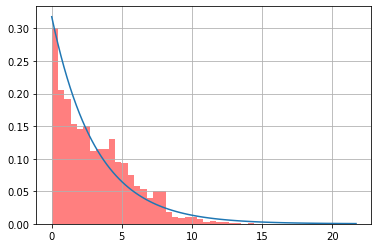

In [294]:
from scipy.stats import expon

nonzero_dd_days = -pct_dd[pct_dd < 0].sort_values()
size = nonzero_dd_days.size

nonzero_dd_days.hist(bins=32, alpha=0.5, density=True, color='red')

params = expon.fit(nonzero_dd_days)

def quantile(p):
  return expon.ppf(p, *params)

xs = np.linspace(quantile(0.001), quantile(0.999), 100)
plt.plot(xs, expon.pdf(xs, *params))

def print_quantile(p):
  theoretical = quantile(p)
  real = nonzero_dd_days[int(size * (1 - p))]
  print(f'{p * 100}% of time expected drawdown is no more than {theoretical:.2f}% theoretically or {real:.2f}% actually')

print('Quantiles:')
for p in [0.50, 0.75, 0.95, 0.99]:
  print_quantile(p)

print(f'Max DD was {nonzero_dd_days[0]:.2f}%')
print(f'Last DD ({pct_dd.index[-1].date()}) was {-pct_dd[-1]:.2f}%')

# Current portfolio

## Structure

In [295]:
last_prices = df.iloc[-1].Close
current_portfolio = result_df.iloc[-1].portfolio
total_value = 0
for asset in current_portfolio.keys():
  total_value += last_prices[asset] * current_portfolio[asset]

for asset in current_portfolio.keys():
  print(f'{asset}: {(last_prices[asset] * current_portfolio[asset]) / total_value:.2f}%')

SPY: 0.26%
TLT: 0.56%
VNQ: 0.18%


## Channels

In [296]:
last_day = df.iloc[-1]

lower = []
upper = []
current = []
defensive = []
index = []
for (risk_asset, config) in CONFIG.items():
  index.append(risk_asset)
  lower.append(last_day.Lower_Channel[risk_asset])
  current.append(last_day.Close[risk_asset])
  upper.append(last_day.Upper_Channel[risk_asset])
  defensive.append(CONFIG[risk_asset]['defensive_asset'])

status_df = pd.DataFrame({'Lower': lower, 'Current price': current, 'Upper': upper, 'Defensive asset': defensive}, index=pd.Index(index, name='Risk asset'))
pd.options.display.float_format = '${:,.2f}'.format
current_assets = list(current_portfolio.keys())
display(
  status_df.reset_index().style.apply(
    lambda col:  [
      'background: lime' if current_assets[i] == asset else ''
      for (i, asset) in enumerate(col)
    ] if col.name in ['Risk asset', 'Defensive asset'] else [''] * len(col), axis = 0
  )
)
pd.options.display.float_format = None




,Risk asset,Lower,Current price,Upper,Defensive asset
0,SPY,365.201935,437.980011,477.709991,IEF
1,GLD,161.320007,171.089996,178.770004,TLT
2,VNQ,82.576805,105.230003,116.010002,IEF
